# Import

In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
import numpy as np
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [2]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return ag

In [3]:
# Load data
df = pd.read_csv('PreprocessedData_v2.txt',
                               sep='\t',
                               decimal=',')
header = df.columns
df_arr =np.array(df, dtype='float64')
df =pd.DataFrame(df_arr, columns=header)

In [4]:
df.head(5)

delta_t    acc0    acc1    acc2   gyro0   gyro1   gyro2    mag0    mag1  \
0   0.0000 -0.0029  0.0003 -0.0003 -0.0194  0.0124 -0.0022 -0.5292 -0.6538   
1   0.0891 -0.0029  0.0013  0.0007 -0.0085  0.0023  0.0006 -0.5292 -0.6538   
2   0.0810 -0.0039  0.0013 -0.0003 -0.0199  0.0086 -0.0024 -0.5162 -0.6538   
3   0.3375 -0.0039  0.0013  0.0007 -0.0216  0.0054 -0.0002 -0.5162 -0.6538   
4   0.0837 -0.0029  0.0023  0.0007 -0.0199  0.0171  0.0005 -0.5292 -0.6538   

     mag2   ...         y      z    beta     Qx     Qy     Qz   Qw  delta_x  \
0 -0.5275   ...     0.221  0.402 -0.0129  0.005  0.020  0.000  1.0      0.0   
1 -0.4945   ...     0.221  0.402 -0.0128  0.005  0.020  0.001  1.0      0.0   
2 -0.5275   ...     0.221  0.402 -0.0133  0.005  0.021  0.000  1.0      0.0   
3 -0.4945   ...     0.221  0.402 -0.0129  0.005  0.020  0.000  1.0      0.0   
4 -0.4945   ...     0.221  0.402 -0.0129  0.005  0.020  0.000  1.0      0.0   

   delta_y  delta_z  
0      0.0      0.0  
1      0.0      0.0  
2      0.0      0.0  
3      0.0      0.0  
4      0.0      0.0  

[5 rows x 21 columns]

In [5]:
split = round(df.shape[0]*0.8)
print(split)

6142


In [6]:
# split into train and test sets
values = df.values
train = values[:split, :]
test = values[split:, :]
# split into input and outputs

#here comes the horizontal separation
train_X, train_y = train[:, :-11], train[:, -3]
test_X, test_y = test[:, :-11], test[:, -3]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(6142, 1, 10) (6142,) (1536, 1, 10) (1536,)


Train on 6142 samples, validate on 1536 samples
Epoch 1/50
 - 4s - loss: 0.1611 - val_loss: 0.2259
Epoch 2/50
 - 0s - loss: 0.1562 - val_loss: 0.2245
Epoch 3/50
 - 0s - loss: 0.1547 - val_loss: 0.2233
Epoch 4/50
 - 0s - loss: 0.1539 - val_loss: 0.2226
Epoch 5/50
 - 0s - loss: 0.1533 - val_loss: 0.2222
Epoch 6/50
 - 0s - loss: 0.1531 - val_loss: 0.2220
Epoch 7/50
 - 0s - loss: 0.1528 - val_loss: 0.2218
Epoch 8/50
 - 0s - loss: 0.1525 - val_loss: 0.2218
Epoch 9/50
 - 0s - loss: 0.1523 - val_loss: 0.2219
Epoch 10/50
 - 0s - loss: 0.1522 - val_loss: 0.2218
Epoch 11/50
 - 0s - loss: 0.1520 - val_loss: 0.2216
Epoch 12/50
 - 0s - loss: 0.1518 - val_loss: 0.2213
Epoch 13/50
 - 0s - loss: 0.1517 - val_loss: 0.2211
Epoch 14/50
 - 1s - loss: 0.1515 - val_loss: 0.2208
Epoch 15/50
 - 1s - loss: 0.1513 - val_loss: 0.2208
Epoch 16/50
 - 0s - loss: 0.1513 - val_loss: 0.2207
Epoch 17/50
 - 0s - loss: 0.1512 - val_loss: 0.2205
Epoch 18/50
 - 0s - loss: 0.1511 - val_loss: 0.2205
Epoch 19/50
 - 0s - loss:

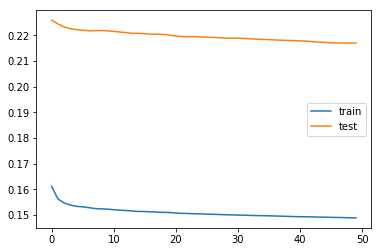

In [7]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [8]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [9]:
# calculate RMSE
rmse = sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.350
